In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Load Modules
sys.path.append('/content/drive/MyDrive/Modules')

Mounted at /content/drive


Using LBFGS!
Using Cuda GPUs
--- 0.049622535705566406 seconds ---
linesearch backtrack
LN 0 alpha=1.000000 fnew=3.226831 fold=2.092004 prod=-0.001020
step size=0.250000
momentum=0.085945
Loss from step function: tensor(2.0920, grad_fn=<AddBackward0>)
[1,     1] loss: 0.018
--- 21.226667642593384 seconds ---
linesearch backtrack
LN 0 alpha=0.352519 fnew=3.185511 fold=2.077229 prod=-0.001348
step size=0.044065
momentum=0.110836
Loss from step function: tensor(2.0772, grad_fn=<AddBackward0>)
[2,     1] loss: 0.018
--- 43.93722915649414 seconds ---
linesearch backtrack
LN 0 alpha=0.257380 fnew=1.931909 fold=2.036313 prod=-0.002750
step size=0.257380
momentum=0.030744
Loss from step function: tensor(2.0363, grad_fn=<AddBackward0>)
[3,     1] loss: 0.017
--- 58.54108786582947 seconds ---
linesearch backtrack
LN 0 alpha=0.209799 fnew=2.233331 fold=1.932205 prod=-0.001454
step size=0.026225
momentum=0.067382
Loss from step function: tensor(1.9322, grad_fn=<AddBackward0>)
[4,     1] loss: 0.016

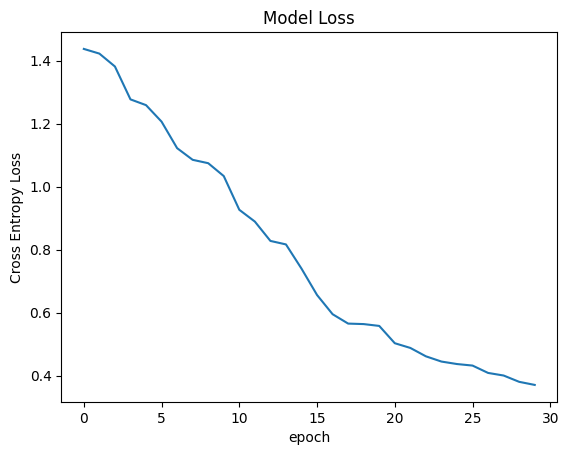

In [6]:
import torch 
import torchvision
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torch.autograd import Variable
from lbfgs_modify import LBFGSModify
import torch.nn.functional as F
import numpy as np
import time
import utils
import autoreload

batch_size = 128
epoch = 30
correct=0
total=0
lambda1=1e-5
lambda2=1e-3
mydevice=torch.device('cpu')
autoreload  # Reload modules

### Data Loading
data_transform=transforms.Compose(
   [transforms.Resize(size=(32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# Setup path to data folder
data_path = Path('/content/drive/MyDrive/Images/') # The classes or folders under here will be used
image_path = data_path / "reducedTgts(64x64)"

# If the image folder doesn't exist, download it and prepare it... 
# if image_path.is_dir():
#    # print(f"{image_path} directory exists.")
# else:
#     print(f"Did not find {image_path} directory")
    
# Setup train and testing paths
train_dir = image_path / "training"
test_dir = image_path / "test"

# Use ImageFolder to create dataset(s)
trainset = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

testset = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform) 

# Get class names as a list
classes = trainset.classes
num_classes= len(classes)
 
# Turn train and test Datasets into DataLoaders
trainloader = DataLoader(dataset=trainset, 
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=testset, 
                             batch_size=batch_size, 
                             num_workers=2, 
                             shuffle=False) # don't usually need to shuffle testing data
#####################################################
def verification_error_check(net):
   correct=0
   total=0
   for data in testloader:
     test_images,test_labels=data
     outputs=net(Variable(test_images).to(mydevice))
     _,predicted=torch.max(outputs.data,1)
     correct += (predicted==test_labels.to(mydevice)).sum()
     total += test_labels.size(0)

   return 100*correct//total
#####################################################
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = F.elu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.elu(out)
        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.linear1 = nn.Linear(32*32, 512) 
        self.linear2 = nn.Linear(512, 512) 
        self.final = nn.Linear(512, 4)
        self.Relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 32*32)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.elu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet9():
    return ResNet(BasicBlock, [1,1,1,1])

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def closure():
        if torch.is_grad_enabled():
         optimizer.zero_grad()
        outputs=net(inputs)

        # Regularization method using L1 and L2 norms to help with overfitting
        # The L1 norm is the sum of the absolute values of the vector. 
        # The L2 norm is the square root of the sum of the squared vector values.
        # Robustness if L1 > L2 thus more resistant to outliers but also sparse
        # Stability if L2 > L1 thus more stable and resistant to horizontal influence but needs more computation 
        L1_penalty=lambda1*(torch.linalg.norm(layer1,1)+torch.linalg.norm(layer2,1)+torch.linalg.norm(layer3,1)+torch.linalg.norm(layer4,1))
        L2_penalty=lambda2*(torch.linalg.norm(layer1,2)+torch.linalg.norm(layer2,2)+torch.linalg.norm(layer3,2)+torch.linalg.norm(layer4,2))
        loss=cross_entropy(outputs,labels)+L1_penalty+L2_penalty   # Cross entropy loss with softmax and penalty

        if loss.requires_grad:
          loss.backward()
        return loss  # Scalar value 
start_time = time.time()
   
if __name__ == '__main__':
    net=ResNet9().to(mydevice)
    cross_entropy = nn.CrossEntropyLoss()  # This combines with softmax
   # optimizer = torch.optim.Adam(net.parameters(), lr=0.001) #e-1
    optimizer=LBFGSModify(net.parameters(), history_size=7, max_iter=2, line_search_fn=True,batch_mode=True,cost_use_gradient=True)  # Using gradient maybe better but takes longer
    base_opt = torch.optim.SGD(net.parameters(), lr=0.1)
    
    use_lbfgs=True
    if not use_lbfgs:
        # Use for Adam
        print("Not using LBFGS!")
    else:
        print("Using LBFGS!")
        
    adam_loss = []
    cnn_loss = []
    # Check cuda availability
    cuda = torch.cuda.is_available()
    # Create neural network model
    if cuda:
        torch.cuda.manual_seed(5)
        model = CNN().cuda() 
        print("Using Cuda GPUs")
    else:
        torch.manual_seed(5)
        model = CNN()
        print("Using CPUs")
    if cuda:
        opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
    else:
        opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
    if cuda:
        predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
    else:
        predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
    accfun = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze())) * 100
    
    # Enter the training loop 
    for epoch in range(epoch):
        net.train() 
        running_loss = 0.0
        print("--- %s seconds ---" % (time.time() - start_time))
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            # wrap them in variable
            inputs,labels=Variable(inputs).to(mydevice),Variable(labels).to(mydevice)
            
            if not use_lbfgs:
                # Use for Adam
                # zero gradients
                optimizer.zero_grad()
                # forward+backward optimize
                outputs=net(inputs)
                loss=cross_entropy(outputs,labels)
                loss.backward()
                adam_loss.append(loss.item())
                optimizer.step()
            else:
            
            # Use for LBFGS
                layer1=torch.cat([x.view(-1) for x in net.layer1.parameters()])
                layer2=torch.cat([x.view(-1) for x in net.layer2.parameters()])
                layer3=torch.cat([x.view(-1) for x in net.layer3.parameters()])
                layer4=torch.cat([x.view(-1) for x in net.layer4.parameters()])    
                outputs=net(inputs)
                # The data tensor list should change after calling optimizer.step(closure)
                optimizer.step(closure)  # 1st call to lbfgs_modify which modifies the data weights
                test_loss=cross_entropy(outputs,labels)
                    
                # print running statistics
                running_loss += test_loss.item()
                
                cnn_loss.append(test_loss.item())
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 80:.3f}')
                running_loss = 0.0
    
    print("--- %s seconds ---" % (time.time() - start_time))
#### Analysis Code ####
# whole dataset
    correct=0
    total=0
    for data in trainloader:
       train_images,train_labels=data
       outputs=net(Variable(train_images).to(mydevice)).cpu()
       _,predicted=torch.max(outputs.data,1)
       total += train_labels.size(0)
       correct += (predicted==train_labels).sum()
       
    print('Accuracy of the network on the %d training images: %d %%'%(total,torch.div(100*correct, total, rounding_mode='trunc')))
       
    correct=0
    total=0
    for data in testloader:
       test_images,test_labels=data
       outputs=net(Variable(test_images).to(mydevice)).cpu()
       _,predicted=torch.max(outputs.data,1) # Predicted labels
       total += test_labels.size(0)  # Number of labels in tensor
       correct += (predicted==test_labels).sum()
       
    print('Accuracy of the network on the %d test images: %d %%'%(total,torch.div(100*correct, total, rounding_mode='trunc')))
    
    class_correct=list(0. for i in range(num_classes))
    class_total=list(0. for i in range(num_classes))
    
    for data in testloader:
      test_images,test_labels=data
      outputs=net(Variable(test_images).to(mydevice)).cpu()
      _,predicted=torch.max(outputs.data,1)
      c=(predicted==test_labels).squeeze()
      for i in range(4):
        label=test_labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
        
    # for i in range(num_classes):
    #   if (class_total[i]==0):
    #       print('Class is 0.0: ',classes[i])
    #   else:
    #     print('Accuracy of %5s : %2d %%' %
    #     (classes[i],100*float(class_correct[i])/float(class_total[i])))
        
   ##### Plots ##### 
    plt.plot(cnn_loss)
    plt.title('Model Loss')
    plt.ylabel('Cross Entropy Loss')
    plt.xlabel('epoch')
    plt.show()
    
    # compute statistics
    # model.eval()
    # train_loss, test_loss, test_acc = utils.compute_stats(train_images, train_labels, test_images, test_labels, opfun, accfun,ghost_batch=128)